# Landscape of (linear/non-linear) one-dimensional convnets with/without normalization

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from include.landscape import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from mpl_toolkits import mplot3d

from matplotlib import gridspec

GPU = False
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor


In [2]:
def loss_eval(x_coordinate,y_coordinate,num_channels,net,net_input,net_target,kernel_size=9,mode='non-learned', \
              act_fun = nn.ReLU()):
    
    X_coordinate, Y_coordinate = np.meshgrid(x_coordinate, y_coordinate)
    Z = np.zeros(X_coordinate.shape)
    depth = len(num_channels)
    
    net_coor = decnet(1,num_channels,kernel_size,act_fun=act_fun,mode=mode,res=False).type(dtype)
    net_coor[len(net)-1][0].weight.data = net[len(net)-1][0].weight.data
    net_coor[len(net)-1][0].bias.data = net[len(net)-1][0].bias.data
    
    net_dir1 = decnet(1,num_channels,kernel_size,act_fun=act_fun,mode=mode,res=False).type(dtype)
    net_dir2 = decnet(1,num_channels,kernel_size,act_fun=act_fun,mode=mode,res=False).type(dtype)
    
    unit_depth = int((len(net)-1)/depth)
    for ii in range(len(x_coordinate)):
        for jj in range(len(y_coordinate)):
            for k in range(len(num_channels)):
                net_coor[unit_depth*k][1].weight.data = net[unit_depth*k][1].weight.data + \
                x_coordinate[ii]*net_dir1[unit_depth*k][1].weight.data + y_coordinate[jj]*net_dir2[unit_depth*k][1].weight.data
            net_out = net_coor(net_input) 
            Z[ii,jj] = nn.MSELoss()(net_out,net_target)
    return X_coordinate, Y_coordinate, Z



def weight_init(m):
    torch.manual_seed(np.random.choice(100, 1))
    if isinstance(m, nn.Linear):
        xavier(m.weight.data)

        
        
def plot_loss_landscape(net_input, net_target, mode = 'non-learned', num_chan = 4, depth = 10, kernel_size = 9, \
                        act_fun =nn.ReLU(), num_iter = 2000):
    num_channels = [num_chan]*depth
    net = decnet(1,num_channels,kernel_size,act_fun= act_fun,mode=mode,res=False).type(dtype)
    # print(net)
    mse_NL, ni, net, out_grads_NL, out_norms = fit(net,net_target,num_channels,net_input = net_input,num_iter = num_iter, \
                                                   LR = 0.1)
    
    x_coordinate = np.linspace(-2,2,30)
    y_coordinate = np.linspace(-2,2,30)
    X_coordinate, Y_coordinate, Z = loss_eval(x_coordinate,y_coordinate,num_channels,net,net_input,net_target,kernel_size,mode,act_fun)
                
    return X_coordinate, Y_coordinate, Z

## Multi-channel CNN with ReLU Layers

### generate signals

In [4]:
n = 256

# noise
shape = [1,1,n]
y = Variable(torch.zeros(shape),requires_grad=False).type(dtype)
y.data.uniform_()
y_np = y.data.cpu().numpy()[0,0]

# step function
ystep_np = np.zeros([1,n])
ystep_np[0,:int(n/2)] = np.ones(int(n/2))
ystep_1 = np_to_var(ystep_np).type(dtype)
# print(ystep.shape)

shape = [1,4,n]
# print("input shape: ", shape)
net_input_1 = Variable(torch.ones(shape)).type(dtype)
net_input_1.data.uniform_()

tensor([[[0.3582, 0.7089, 0.7062,  ..., 0.3017, 0.9311, 0.3785],
         [0.7115, 0.7537, 0.7227,  ..., 0.1194, 0.8146, 0.6724],
         [0.5433, 0.7547, 0.6865,  ..., 0.5804, 0.6257, 0.8561],
         [0.8582, 0.7718, 0.0284,  ..., 0.7802, 0.1843, 0.7593]]])

### With Channel Normalization

input provided
optimize with SGD 0.1


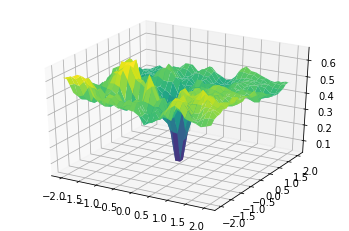

In [5]:
X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_1, ystep_1, mode = 'non-learned')

fig = plt.figure()
fig = plt.axes(projection='3d')
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

### Without Normalization

input provided
optimize with SGD 0.1


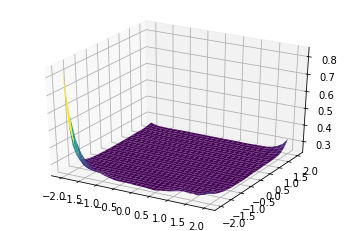

In [7]:
X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_1, ystep_1, mode = 'linear')

fig = plt.figure()
fig = plt.axes(projection='3d')
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

## Single-channel linear CNN

### Generate Signals

In [9]:
n = 64

# noise
shape = [1,1,n]
y = Variable(torch.zeros(shape),requires_grad=False).type(dtype)
y.data.uniform_()
y_np = y.data.cpu().numpy()[0,0]

# step function
ystep_np = np.zeros([1,n])
ystep_np[0,:int(n/3)] = np.ones(int(n/3))
ystep_2 = np_to_var(ystep_np).type(dtype)

net_input_2 = Variable(torch.ones(shape)).type(dtype)
net_input_2.data.uniform_()
print(net_input_2.shape)


torch.Size([1, 1, 64])


### With Channel Normalization

input provided
optimize with SGD 0.1


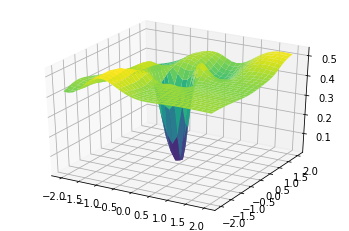

In [10]:
X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_2, ystep_2, mode = 'non-learned', num_chan = 1, act_fun = None)

fig = plt.figure()
fig = plt.axes(projection='3d')
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

### Without Normalization

input provided
optimize with SGD 0.1


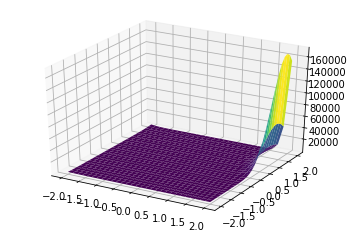

In [11]:
X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_2, ystep_2, mode = 'linear', num_chan = 1, act_fun = None)

fig = plt.figure()
fig = plt.axes(projection='3d')
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')

## Combine the Figures

input provided
optimize with SGD 0.1
input provided0    Train loss 0.000005                                                                                                    
optimize with SGD 0.1
input provided0    Train loss 0.249999                                                                                                                                                                                                        
optimize with SGD 0.1
input provided0    Train loss 0.009534                                                                                                                                                                                                        
optimize with SGD 0.1


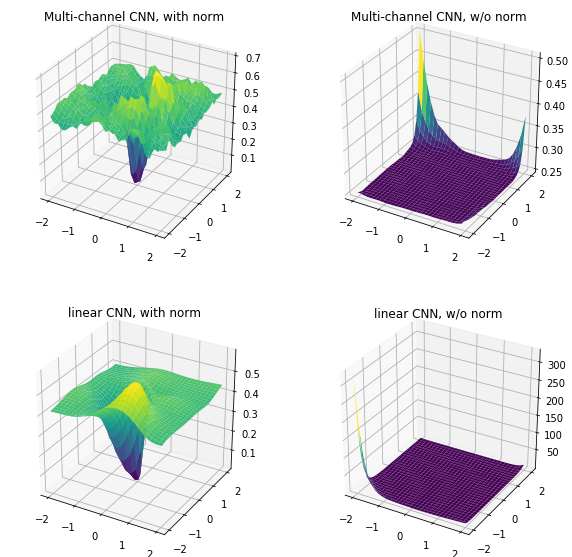

In [29]:
from matplotlib import gridspec

plot = plt.figure(figsize=(10,10))

X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_1, ystep_1, mode = 'non-learned',num_iter=1000)
fig = plot.add_subplot(2, 2, 1, projection='3d')
fig.set_title("Multi-channel CNN, with norm")
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_1, ystep_1, mode = 'linear')
fig = plot.add_subplot(2, 2, 2, projection='3d')
fig.set_title("Multi-channel CNN, w/o norm")
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')


X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_2, ystep_2, mode = 'non-learned', num_chan = 1, act_fun = None)
fig = plot.add_subplot(2, 2, 3, projection='3d')
fig.set_title("linear CNN, with norm")
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

X_coordinate, Y_coordinate, Z = plot_loss_landscape(net_input_2, ystep_2, mode = 'linear', num_chan = 1, act_fun = None)
fig = plot.add_subplot(2, 2, 4, projection='3d')
fig.set_title("linear CNN, w/o norm")
fig.plot_surface(X_coordinate, Y_coordinate, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')